In [1]:
# === Colab environment setup ===
# Run this cell first (installs required packages).
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q timm
!pip install -q fastprogress
!pip install -q uvicorn fastapi python-multipart pillow aiofiles

# For visualization
!pip install -q matplotlib seaborn


In [2]:
from google.colab import drive
import os

# ✅ Mount Google Drive (so models and data persist)
drive.mount('/content/drive')

# ✅ Define root directory (change path if needed)
ROOT_DIR = "/content/drive/MyDrive/PlantVillage"

# ✅ Create folders
os.makedirs(f"{ROOT_DIR}/dataset", exist_ok=True)
os.makedirs(f"{ROOT_DIR}/model", exist_ok=True)

print("📁 Folder structure created successfully!")


Mounted at /content/drive
📁 Folder structure created successfully!


In [4]:
!unzip "/content/drive/MyDrive/PlantVillage/dataset/Data.zip" \
       -d "//content/drive/MyDrive/PlantVillage/dataset/"


Streaming output truncated to the last 5000 lines.
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d7ce9c0e-ac95-46e6-8578-80c712d1a44a___GCREC_Bact.Sp 3606.JPG  
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d7f580f8-c7b1-47ff-9746-35f6f7000427___GCREC_Bact.Sp 3600.JPG  
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d8218386-5974-4ab6-b453-6d628317d82d___GCREC_Bact.Sp 6232.JPG  
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d8914e04-4e33-4189-bfa9-f547e5f696d1___GCREC_Bact.Sp 3173.JPG  
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d8a64b79-e21e-4158-9d9d-47bd6e44fba0___GCREC_Bact.Sp 3594.JPG  
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d8a90b81-eb30-461d-80ba-4fa9c93f379d___GCREC_Bact.Sp 3757.JPG  
  inflating: //content/drive/MyDrive/PlantVillage/dataset/Tomato_Bacterial_spot/d8b6f

In [5]:
import os
import shutil
import random
from pathlib import Path

def train_val_test_split(src_folder, dest_root, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    random.seed(seed)
    src = Path(src_folder)
    dest_root = Path(dest_root)

    # Iterate over each class folder
    for cls in [d for d in src.iterdir() if d.is_dir()]:
        imgs = list(cls.glob('*'))
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        # Split images
        train_imgs = imgs[:n_train]
        val_imgs = imgs[n_train:n_train+n_val]
        test_imgs = imgs[n_train+n_val:]

        # Copy images to respective folders
        for t, lst in [('train', train_imgs), ('valid', val_imgs), ('test', test_imgs)]:
            out_dir = dest_root / t / cls.name
            out_dir.mkdir(parents=True, exist_ok=True)
            for img in lst:
                shutil.copy(img, out_dir / img.name)

    print("✅ Dataset split completed!")

# Example usage:
train_val_test_split("/content/drive/MyDrive/PlantVillage/dataset", "/content/drive/MyDrive/PlantVillage/dataset/PlantVillage_split", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


✅ Dataset split completed!


In [6]:
import os
from pathlib import Path
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json


In [7]:
# Paths
DATA_ROOT = Path("/content/drive/MyDrive/PlantVillage/dataset/PlantVillage_split")  # change if needed
MODEL_DIR = Path("/content/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 10      # increase if you have time
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [16]:
# ✅ PlantVillage Dataset Loader with Advanced Data Augmentation
# --------------------------------------------------------------
import os
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

# -----------------------------
# Paths (update if needed)
# -----------------------------
base_dir = "/content/drive/MyDrive/PlantVillage/dataset/PlantVillage_split"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

# -----------------------------
# Device setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")

# -----------------------------
# Data augmentation
# -----------------------------
# 🌿 Strong but realistic augmentations for plants
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),                  # Resize slightly bigger for random crop
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Random zoom & crop
    transforms.RandomHorizontalFlip(p=0.5),         # Flip horizontally
    transforms.RandomVerticalFlip(p=0.2),           # Occasionally flip vertically
    transforms.RandomRotation(25),                  # Rotate up to ±25 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  # Lighting variation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight shift
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), # Blur to simulate focus issues
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Validation/Test should not augment
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# -----------------------------
# Helper functions
# -----------------------------
def is_valid_image(path):
    valid_exts = ('.jpg', '.jpeg', '.png')
    return path.lower().endswith(valid_exts)

def clean_hidden_dirs(root_dir):
    """Remove hidden system folders like .ipynb_checkpoints."""
    for root, dirs, files in os.walk(root_dir):
        for d in dirs:
            if d.startswith('.'):
                full_path = os.path.join(root, d)
                print(f"🧹 Removing hidden folder: {full_path}")
                os.system(f"rm -rf '{full_path}'")

# -----------------------------
# Clean dataset directories
# -----------------------------
clean_hidden_dirs(train_dir)
clean_hidden_dirs(valid_dir)
clean_hidden_dirs(test_dir)

# -----------------------------
# Datasets
# -----------------------------
train_ds = datasets.ImageFolder(root=train_dir, transform=train_transforms, is_valid_file=is_valid_image)
valid_ds = datasets.ImageFolder(root=valid_dir, transform=val_transforms, is_valid_file=is_valid_image)
test_ds  = datasets.ImageFolder(root=test_dir,  transform=val_transforms, is_valid_file=is_valid_image)

# -----------------------------
# Dataloaders
# -----------------------------
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# -----------------------------
# Check summary
# -----------------------------
print("\n📊 Dataset Summary:")
print(f"Train images: {len(train_ds)}")
print(f"Validation images: {len(valid_ds)}")
print(f"Test images: {len(test_ds)}")
print(f"Classes: {train_ds.classes}")


✅ Device: cuda
🧹 Removing hidden folder: /content/drive/MyDrive/PlantVillage/dataset/PlantVillage_split/train/.ipynb_checkpoints
🧹 Removing hidden folder: /content/drive/MyDrive/PlantVillage/dataset/PlantVillage_split/valid/.ipynb_checkpoints
🧹 Removing hidden folder: /content/drive/MyDrive/PlantVillage/dataset/PlantVillage_split/test/.ipynb_checkpoints

📊 Dataset Summary:
Train images: 16504
Validation images: 2058
Test images: 2076
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [17]:
def build_model(num_classes, pretrained=True, dropout_p=0.3):
    model = models.resnet50(pretrained=pretrained)
    # Replace top
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model

num_classes = len(train_ds.classes)
model = build_model(num_classes, pretrained=True).to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# ✅ remove 'verbose' argument for compatibility
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)


In [20]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc="Train batches", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Val batches", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

best_val_loss = float('inf')
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, valid_loader, criterion, device)
    t1 = time.time()
    epoch_time = t1 - t0
    print(f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"Val   loss: {val_loss:.4f}, acc: {val_acc:.4f}  (epoch time {epoch_time:.1f}s)")
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    scheduler.step(val_loss)
    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_to_idx': train_ds.class_to_idx
        }, MODEL_DIR / "best_resnet50.pth")
        print("Saved best model.")



Epoch 1/10


Train loss: 0.4399, acc: 0.8586
Val   loss: 0.3169, acc: 0.9150  (epoch time 285.3s)
Saved best model.

Epoch 2/10


Train loss: 0.2171, acc: 0.9291
Val   loss: 0.1608, acc: 0.9393  (epoch time 286.7s)
Saved best model.

Epoch 3/10


Train loss: 0.1701, acc: 0.9456
Val   loss: 0.1137, acc: 0.9645  (epoch time 284.3s)
Saved best model.

Epoch 4/10


Train loss: 0.1483, acc: 0.9515
Val   loss: 0.0833, acc: 0.9708  (epoch time 285.1s)
Saved best model.

Epoch 5/10


Train loss: 0.1333, acc: 0.9543
Val   loss: 0.0922, acc: 0.9684  (epoch time 288.1s)

Epoch 6/10


Train loss: 0.1255, acc: 0.9592
Val   loss: 0.0520, acc: 0.9820  (epoch time 286.8s)
Saved best model.

Epoch 7/10


Train loss: 0.1101, acc: 0.9622
Val   loss: 0.0591, acc: 0.9791  (epoch time 285.3s)

Epoch 8/10


Train loss: 0.0985, acc: 0.9665
Val   loss: 0.0410, acc: 0.9874  (epoch time 287.6s)
Saved best model.

Epoch 9/10


Train loss: 0.0955, acc: 0.9675
Val   loss: 0.0666, acc: 0.9767  (epoch time 286.1s)

Epoch 10/10


Train loss: 0.0926, acc: 0.9699
Val   loss: 0.0905, acc: 0.9728  (epoch time 289.0s)


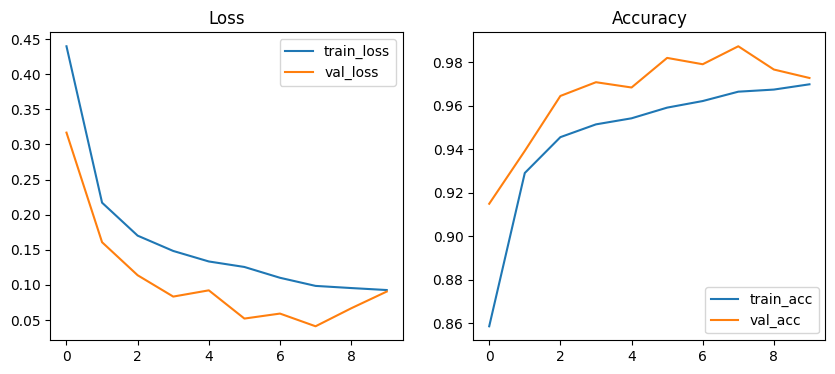

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label='train_loss')
plt.plot(history["val_loss"], label='val_loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label='train_acc')
plt.plot(history["val_acc"], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.show()


Test: 100%|██████████| 65/65 [00:14<00:00,  4.35it/s]


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.78      0.98      0.87       101
                     Pepper__bell___healthy       0.99      1.00      0.99       149
                      Potato___Early_blight       1.00      0.74      0.85       100
                       Potato___Late_blight       0.98      1.00      0.99       100
                           Potato___healthy       1.00      1.00      1.00        16
                      Tomato_Bacterial_spot       1.00      0.99      0.99       214
                        Tomato_Early_blight       0.99      0.96      0.97       100
                         Tomato_Late_blight       1.00      0.97      0.99       192
                           Tomato_Leaf_Mold       0.99      0.96      0.97        96
                  Tomato_Septoria_leaf_spot       0.97      0.99      0.98       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.97      0.98

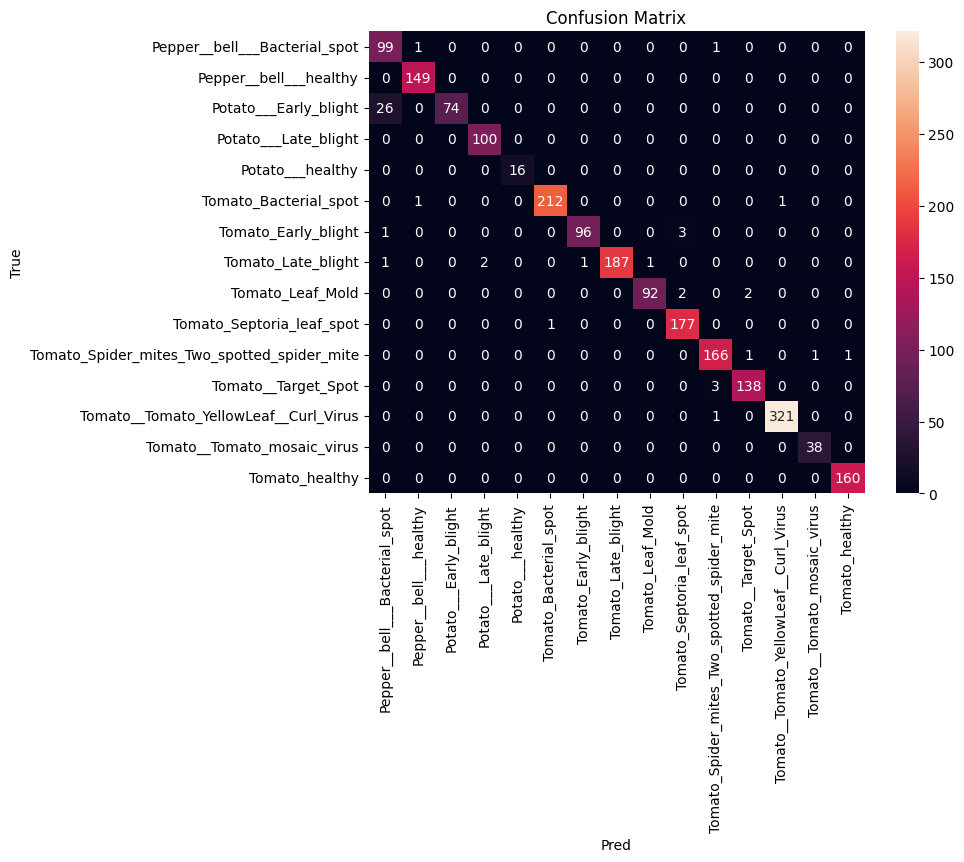

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test"):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=test_ds.classes))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [23]:
# Save final model (state dict saved already for best). Save a full serialized model for easy loading.
checkpoint = torch.load(MODEL_DIR / "best_resnet50.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Save full torchscript for easier production use (optional)
example_input = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(device)
traced_script_module = torch.jit.trace(model.to('cpu'), example_input.to('cpu'))
traced_script_module.save(MODEL_DIR / "resnet50_traced.pt")

# Save class mapping
with open(MODEL_DIR / "class_to_idx.json","w") as f:
    json.dump(train_ds.class_to_idx, f)
print("Saved model and mapping.")


Saved model and mapping.
